In [ ]:
# add the necessary libraries
import pandas as pd
from astropy.io import fits
import os
from tqdm import tqdm
import numpy as np

In [2]:
# Define the path to the FITS file and the spectra folder
path_catalog = '/Users/mginolfi/Projects/Beta/dx-quasars_v1_sdss_sp-prop.fits'
path_spectra = '/Users/mginolfi/Projects/Beta/spectra'
output_path = '/Users/mginolfi/Projects/Beta/quasars_spectra_combined.fits'

# Format the filename
def format_filename(plate, mjd, fiberid):
    """
    Formats the filename for a given plate, MJD, and fiber ID.

    Args:
        plate (int): The plate number.
        mjd (int): The Modified Julian Date.
        fiberid (int): The fiber ID.

    Returns:
        str: The formatted filename in the format 'spec-plate-mjd-fiberid.fits'.
    """
    return f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiberid):04d}.fits"

In [ ]:
"""read the file and adjust spectra with zero padding in a common wavelenght grid"""

# Two-Pass Method for Processing Spectra (needed to handle memory problems -- too many files opened -- an alternative is opening files in batches):
# Pass 1: Collect min/max loglam values and resolution across all spectra to establish a common grid.
# Pass 2: Pad each spectrum to the common grid and append it, along with its loglam, as new columns to the master FITS table.


# Open the original master table FITS file
# with fits.open(path_catalog) as hdul:

#     master_table = hdul[1].data

    # # Initialize variables for common grid calculation
    # all_min_loglam = []
    # all_max_loglam = []
    # all_resolutions = []

    # # First pass: Collect information for common grid calculation
    # for row in tqdm(master_table):

    #     filename = format_filename(row['PLATE_1'], row['MJD_1'], row['FIBERID_1'])
    #     file_path = os.path.join(path_spectra, filename)

    #     if os.path.exists(file_path):
    #         with fits.open(file_path) as hdul_spec:
    #             loglam = hdul_spec[1].data['loglam']
    #             if loglam is not None and len(loglam) > 1:
    #                 all_min_loglam.append(np.min(loglam))
    #                 all_max_loglam.append(np.max(loglam))
    #                 all_resolutions.append(np.min(np.diff(loglam)))
                    
                    
    # # Calculate min and max loglam and resolution
    # min_loglam = np.nanmin(all_min_loglam)
    # max_loglam = np.nanmax(all_max_loglam)
    # resolution =  0.0001 # I choose a fixed value that I verified manually (an alternative is the line below)
    # # resolution = np.nanmin(all_resolutions)
    
# the above code is commented because I ran it once and already know the min and max values of loglam and the resolution

# # Create the common grid
min_loglam = 3.5498
max_loglam = 4.0173
resolution = 0.0001

In [ ]:
# Second pass: Process the spectra and pad them to the common grid

# Open the original master table FITS file
with fits.open(path_catalog) as hdul:

    master_table = hdul[1].data

    # Create the common grid
    common_loglam = np.arange(min_loglam, max_loglam + resolution, resolution)

    # Initialize lists for the padded data and a list for rows to keep
    all_flux = []
    all_loglam = []
    rows_to_keep = []

    # Second pass: Process the spectra and pad them to the common grid
    for i, row in enumerate(tqdm(master_table, desc='Processing')):
        filename = format_filename(row['PLATE_1'], row['MJD_1'], row['FIBERID_1'])
        file_path = os.path.join(path_spectra, filename)

        if os.path.exists(file_path):
            with fits.open(file_path) as hdul_spec:
                flux = hdul_spec[1].data['flux']
                loglam = hdul_spec[1].data['loglam']

                # Pad the spectrum to match the common grid
                padded_flux = np.zeros_like(common_loglam)
                start_idx = np.searchsorted(common_loglam, loglam[0])
                end_idx = start_idx + len(loglam)
                padded_flux[start_idx:end_idx] = flux

                # Append the padded data
                all_flux.append(padded_flux)
                all_loglam.append(common_loglam)
                
                # this is needed because not always the entries have an associated spectrum
                rows_to_keep.append(i)

    # Create new FITS columns for the filtered data
    col_flux = fits.Column(name='FLUX', array=np.array(all_flux), format=f'{len(common_loglam)}E')
    col_loglam = fits.Column(name='LOGLAM', array=np.array(all_loglam), format=f'{len(common_loglam)}E')

    # Define new columns combining original and new ones
    original_cols = hdul[1].columns
    new_columns = original_cols + col_flux + col_loglam

    # Create a new FITS table with the filtered data and new columns
    new_hdu = fits.BinTableHDU.from_columns(new_columns, nrows=len(rows_to_keep))
    for colname in original_cols.names:
        new_hdu.data[colname] = master_table[colname][rows_to_keep]

    # Save the new FITS file
    new_hdu.writeto(output_path, overwrite=True)

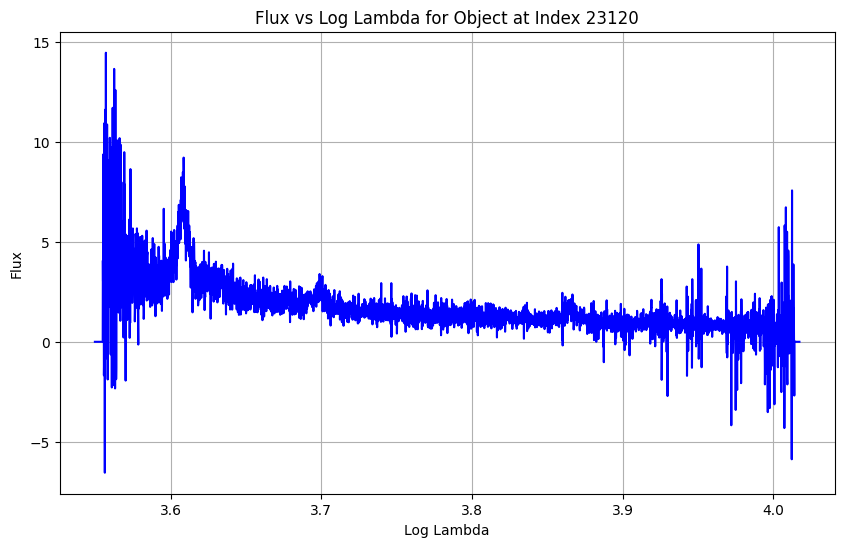

In [3]:
# example -> reading a spectrum from the new FITS file and plotting it

from astropy.io.fits import open as open_fits
import matplotlib.pyplot as plt

# Path to the updated FITS file
fits_path = '/Users/mginolfi/Projects/Beta/quasars_spectra_combined.fits'

# Index of the object to plot
index = 23120  # any number, just to visualise

hdu = open_fits(fits_path)

master_table = hdu[1].data

# Extract the spectrum (FLUX) and loglam for the given index
spectrum = master_table['FLUX'][index]
loglam = master_table['LOGLAM'][index]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loglam, spectrum, color='blue')
plt.xlabel('Log Lambda')
plt.ylabel('Flux')
plt.title(f'Flux vs Log Lambda for Object at Index {index}')
plt.grid(True)
plt.show()